# Lab 01 Convolutional classifier
<br>

<center>
    
<img src="img/craiyon-convolutions.jpg" alt="Spam" width="300"/> 
    
    Craiyon.com "Convolutions" 
    
</center>    

<br>

## Introduction

Have you ever wanted to teach a computer to see? In these notebooks, that's exactly what you'll do!

- Use modern deep-learning networks to build an **image classifier** with Keras
- Design your own **custom convnet** with reusable blocks
- Learn the fundamental ideas behind visual **feature extraction**
- Master the art of **transfer learning** to boost your models
- Utilize **data augmentation** to extend your dataset



## 1 Objectives

This Notebook will introduce you to the fundamental ideas of computer vision. The goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

This notebook:
- Convolutional neural network (CNN) basics
- Training a CNN

The neural networks that are best at this task are called **convolutional neural networks** (Sometimes we say **convnet** or **CNN** instead.) Convolution is the mathematical operation that gives the layers of a convnet their unique structure. In future lessons, you'll learn why this structure is so effective at solving computer vision problems.

We will apply these ideas to the problem of **image classification**: given a picture, can we train a computer to tell us what it's a picture *of*? You may have seen [apps](https://identify.plantnet.org/) that can identify a species of plant from a photograph. That's an image classifier! In this course, you'll learn how to build image classifiers just as powerful as those used in professional applications.

While our focus will be on image classification, what you'll learn is relevant to every kind of computer vision problem. At the end, you'll be ready to move on to more advanced applications like generative adversarial networks and image segmentation.



## 2 The Convolutional Classifier

A convnet used for image classification consists of two parts: a **convolutional base** and a **dense head**.

<center>
<!-- <img src="./images/1-parts-of-a-convnet.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">-->
<img src="img\1-1.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">
</center>

<br>

The base is used to **extract the features** from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. (You'll learn about these in the next lesson.)

The head is used to **determine the class** of the image. It is formed primarily of dense layers, but might include other layers like dropout. 

What do we mean by visual feature? A feature could be a line, a color, a texture, a shape, a pattern -- or some complicated combination.

The whole process goes something like this:

<center>
<!-- <img src="./images/1-parts-of-a-convnet.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">-->
<img src="img\1-2.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">
</center>

<br>
The features actually extracted look a bit different, but this gives the idea conceptually.

## 3 Training the Classifier

The goal of the network during training is to learn two things:
1. which features to extract from an image (base),
2. which class goes with what features (head).

These days, convnets are rarely trained from scratch. More often, we **reuse the base of a pretrained model**. To the pretrained base we then **attach an untrained head**. In other words, we reuse the part of a network that has already learned to do *1. Extract features*, and attach to it some fresh layers to learn *2. Classify*.

<center>
<!-- <img src="./images/1-attach-head-to-base.png" width="400" alt="Attaching a new head to a trained base."> -->
<img src="img\1-3.png" width="400" alt="Attaching a new head to a trained base.">
</center>

<br>

Because the head usually consists of only a few dense layers, very accurate classifiers can be created from relatively little data. 

Reusing a pretrained model is a technique known as **transfer learning**. It is so effective, that almost every image classifier these days will make use of it.

## 4 Example - Train a Convnet Classifier

We're going to be creating classifiers that attempt to solve the following problem: is this a picture of a *Car* or of a *Truck*? Our dataset is about 10,000 pictures of various automobiles, around half cars and half trucks.

### 4.1 - Load Data

This next cell will import some libraries and set up our data pipeline. We have a training split called `ds_train` and a validation split called `ds_valid`.

In [4]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'data/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


<br>

Let's take a look at a few examples from the training set.

Populating the interactive namespace from numpy and matplotlib


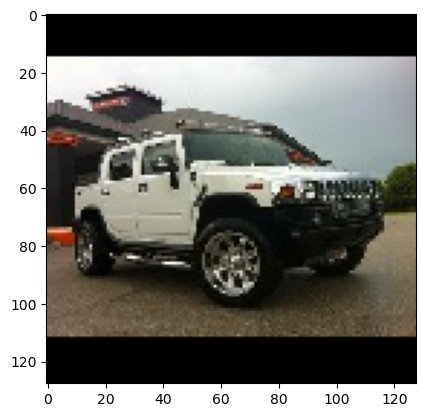

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('data/car-or-truck/train/Truck/00001.jpeg') # hummer omg
imgplot = plt.imshow(img)
plt.show()


### 4.2 - Define Pretrained Base 

A popular dataset for pretraining is [*ImageNet*](http://image-net.org/about-overview), a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its [`applications` module](https://www.tensorflow.org/api_docs/python/tf/keras/applications). The specific pretrained model we'll use is called **VGG16**.

In [7]:
# possibly warnings
pretrained_base = tf.keras.models.load_model(
    'data/vgg16-pretrained-base',
)
pretrained_base.trainable = False

### 4.3 - Attach Head

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first `Dense` layer) followed by a layer to transform the outputs to a probability score for class 1, `Truck`. The `Flatten` layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

### 4.4 - Train 

Finally, let's train the model. Since this is a two-class problem, we'll use the binary versions of `crossentropy` and `accuracy`. The `adam` optimizer generally performs well, so we'll choose it as well.

In [ ]:
# Might need colab GPU

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

<br>

When training a neural network, it's always a good idea to examine the loss and metric plots. The `history` object contains this information in a dictionary `history.history`. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

In [ ]:
# might need colab
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

## 5 Conclusion

In this notebook, we learned about the structure of a convnet classifier: a **head** to act as a classifier atop of a **base** which performs the feature extraction.

The head, essentially, is an ordinary classifier like you learned about in the introductory course. For features, it uses those features extracted by the base. This is the basic idea behind convolutional classifiers: that we can attach a unit that performs feature engineering to the classifier itself.

This is one of the big advantages deep neural networks have over traditional machine learning models: given the right network structure, the deep neural net can learn how to engineer the features it needs to solve its problem.

For the next few lessons, we'll take a look at how the convolutional base accomplishes the feature extraction. Then, you'll learn how to apply these ideas and design some classifiers of your own.

## 6 Exercises

In the tutorial, we saw how to build an image classifier by attaching a head of dense layers to a pretrained base. The base we used was from a model called **VGG16**. We saw that the VGG16 architecture was prone to overfitting this dataset. Over this course, you'll learn a number of ways you can improve upon this initial attempt.

The first way you'll see is to use a base more appropriate to the dataset. The base this model comes from is called **InceptionV1** (also known as GoogLeNet). InceptionV1 was one of the early winners of the ImageNet competition. One of its successors, InceptionV4, is among the state of the art today.

To get started, run the code cell below to set everything up.

In [2]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'data/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


<br>

The **InceptionV1** model pretrained on ImageNet is available in the [TensorFlow Hub](https://www.tensorflow.org/hub/) repository, but we'll load it from a local copy. Run this cell to load InceptionV1 for your base.

In [4]:
# pip install tensorflow_hub
import tensorflow_hub as hub

pretrained_base = tf.keras.models.load_model(
    'data/inceptionv1'
)

### 6.1 Define Pretrained Base #

Now that you have a pretrained base to do our feature extraction, decide whether this base should be trainable or not.

In [ ]:
# YOUR_CODE_HERE
pretrained_base.trainable = ____



### 6.2 Attach Head

Now that the base is defined to do the feature extraction, create a head of `Dense` layers to perform the classification, following this diagram:

<center><figure>
<img src="img/1-4.png" alt="Diagram of the dense head.">
</figure></center>


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    # YOUR CODE HERE. Attach a head of dense layers.
    # ____
])


### 6.3 Train

Before training a model in Keras, you need to specify an *optimizer* to perform the gradient descent, a *loss function* to be minimized, and (optionally) any *performance metrics*. The optimization algorithm we'll use for this course is called ["Adam"](https://keras.io/api/optimizers/adam/), which generally performs well regardless of what kind of problem you're trying to solve.

The loss and the metrics, however, need to match the kind of problem you're trying to solve. Our problem is a **binary classification** problem: `Car` coded as 0, and `Truck` coded as 1. Choose an appropriate loss and an appropriate accuracy metric for binary classification.

In [ ]:
# YOUR CODE HERE: what loss function should you use for a binary
# classification problem? (Your answer for each should be a string.)
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = ____,
    metrics=[____],
)



In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
)

<br>

Run the cell below to plot the loss and metric curves for this training run.

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

### 6.4 Examine Loss and Accuracy #

Do you notice a difference between these learning curves and the curves for VGG16 from the tutorial? What does this difference tell you about what this model (InceptionV2) learned compared to VGG16? Are there ways in which one is better than the other? Worse?

After you've thought about it, run the cell below to see the answer.

## 7 Conclusion

In this first lesson, you learned the basics of **convolutional image classifiers**, that they consist of a **base** for extracting features from images, and a **head** which uses the features to decide the image's class. You also saw how to build a classifier with **transfer learning** on pretrained base. 